In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

### For a single recording - merging catagorised fixations and categories face landmarks files ###

In [6]:
# Get participant number input
participant_number = input("Enter participant number: ")

# Define the base path
base_path = "/Users/alina/Downloads/Thesis/raw/"

# Build the folder path for the participant
folder_path = os.path.join(base_path, f"Participant {participant_number}")

# Get recording number input
recording_number = input("Enter recording number: ")

# Build the recording folder path
recording_path = os.path.join(folder_path, f"P{participant_number}_{recording_number}")

# Read the CSV files with dynamic paths
face_landmarks_file = os.path.join(recording_path, f"face_landmarks_{participant_number}_{recording_number}.csv")
fixations_on_everything_file = os.path.join(recording_path, f"fixations_on_everything_{participant_number}_{recording_number}.csv")
events_file = os.path.join(recording_path, f"events.csv")

# Load the data
face_landmarks_df = pd.read_csv(face_landmarks_file)
fixations_on_everything_df = pd.read_csv(fixations_on_everything_file)
events_df = pd.read_csv(events_file)

## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a DataFrame to include only rows where the timestamp falls within any given intervals.

    Parameters:
        df: The DataFrame to filter.
        intervals (list of tuple): List of (start_time, end_time) pairs.
        timestamp_col (str): Name of the timestamp column.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows in any of the intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]

events_df = events_df.sort_values("timestamp [ns]")

# Filter for events where name == 'A'
A_events = events_df[events_df["name"] == "A"]
B_events = events_df[events_df["name"] == "B"]
C_events = events_df[events_df["name"] == "C"]
D_events = events_df[events_df["name"] == "D"]

# Get the highest (except D) and lowest (except A) timestamp from that filtered DataFrame
max_timestamp_A = A_events["timestamp [ns]"].max()
min_timestamp_B = B_events["timestamp [ns]"].min()

max_timestamp_B = B_events["timestamp [ns]"].max()
min_timestamp_C = C_events["timestamp [ns]"].min()

max_timestamp_C = C_events["timestamp [ns]"].max()
min_timestamp_D = D_events["timestamp [ns]"].min()

# intervals to use for filter_by_intervals function
intervals = [
    (max_timestamp_A, min_timestamp_B),
    (max_timestamp_B, min_timestamp_C),
    (max_timestamp_C, min_timestamp_D)
]
fixations_on_everything_df = filter_by_intervals(fixations_on_everything_df, intervals)

In [7]:
## to combine all categorized fixations

fixations_on_everything_df = fixations_on_everything_df.sort_values(["fixation id", "timestamp [ns]"])

face_landmarks_df = face_landmarks_df.rename(columns={"fixation id_x":'fixation id'})

face_landmarks_df = face_landmarks_df.sort_values(["fixation id"])


merged_df = fixations_on_everything_df.merge(
    face_landmarks_df,
    on="fixation id",
    how="left",
    suffixes=("", "_lm")
)

all_fixations = []

for _,row in merged_df.iterrows():
    if pd.notna(row['assigned_aoi']):
        type = row['assigned_aoi']
    else:
        type = row['type']

    all_fixations.append({
        'start timestamp [ns]': row['timestamp [ns]'],
        'type': type,
        'fixation id': row['fixation id'],
        'duration [ms]':row['duration [ms]']
    })

all_fixations_df = pd.DataFrame(all_fixations)

In [17]:
all_fixations_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6164 entries, 0 to 6163
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   start timestamp [ns]  6164 non-null   int64  
 1   type                  6164 non-null   object 
 2   fixation id           6164 non-null   int64  
 3   duration [ms]         6164 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 192.8+ KB


Normalized Transition Matrix:
 [[0.         0.30449086 0.69550914]
 [0.00369042 0.47250513 0.52380446]
 [0.00184499 0.2950438  0.70311121]]

Flattened Feature Vector:
 [0.         0.30449086 0.69550914 0.00369042 0.47250513 0.52380446
 0.00184499 0.2950438  0.70311121]


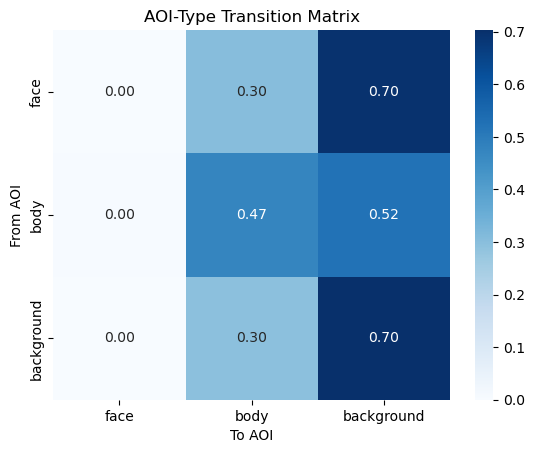

Raw Transition Matrix (Counts):
 [[     0.      1181.008   2697.624]
 [  2185.    279758.    310131.   ]
 [  2141.902 342524.014 816260.084]]


In [8]:
# for 1 p

### for one recording
df_markov = all_fixations_df.rename(columns={
    'timestamp [ns]': 'timestamp',
    'fixation id': 'fixation_id',
    'duration [ms]': 'duration'
})

# Sort by fixation order
df_markov = df_markov.sort_values(by='fixation_id').reset_index(drop=True)

aoi_types = ['face', 'body', 'background'] #, 'left_eye', 'right_eye', 'nose', 'mouth']
aoi_index = {aoi: i for i, aoi in enumerate(aoi_types)}

transition_matrix = np.zeros((3, 3))
for i in range(len(df_markov) - 1):
    from_aoi = df_markov.loc[i, 'type']
    to_aoi = df_markov.loc[i + 1, 'type']

    if from_aoi in aoi_index and to_aoi in aoi_index:
        #transition_matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += 1
        # if i want to use also durations as weights in the matrix
        weight = df_markov.loc[i, 'duration']
        transition_matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += weight

def row_normalize(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_matrix = np.divide(matrix, row_sums, where=row_sums != 0)
    return norm_matrix

# Compute matrix
#transition_matrix = compute_duration_weighted_matrix_from_df(df_markov)

# Normalize (choose row or L2)
transition_matrix_normalized = row_normalize(transition_matrix)

# Optional: flatten for feature vector
feature_vector = transition_matrix_normalized.flatten()

print("Normalized Transition Matrix:\n", transition_matrix_normalized)
print("\nFlattened Feature Vector:\n", feature_vector)

def plot_matrix(matrix, title="AOI-Type Transition Matrix"):
    df_plot = pd.DataFrame(matrix, index=aoi_types, columns=aoi_types)
    sns.heatmap(df_plot, annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.xlabel("To AOI")
    plt.ylabel("From AOI")
    plt.show()

plot_matrix(transition_matrix_normalized)
print("Raw Transition Matrix (Counts):\n", transition_matrix)

# Transition matrix - all recordings

Combined duration-weighted AOI transition matrix (row-normalized):
 [[0.39123062 0.31419574 0.29457364]
 [0.01713742 0.52382188 0.4590407 ]
 [0.00688289 0.2277284  0.76538871]]

Flattened feature vector:
 [0.39123062 0.31419574 0.29457364 0.01713742 0.52382188 0.4590407
 0.00688289 0.2277284  0.76538871]


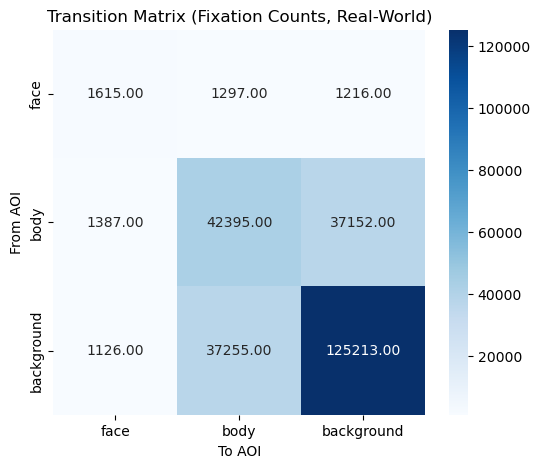

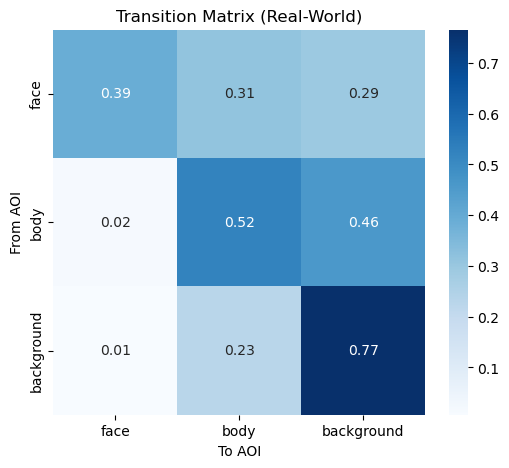

In [5]:
base_path = "/Users/alina/Downloads/Thesis/raw"

aoi_types = ['face', 'body', 'background']
aoi_index = {aoi: i for i, aoi in enumerate(aoi_types)}

def compute_duration_weighted_matrix(df):
    matrix = np.zeros((3, 3))
    df = df.sort_values(by=['participant', 'recording', 'fixation id']).reset_index(drop=True)

    for i in range(len(df) - 1):
        from_aoi = df.loc[i, 'type']
        to_aoi = df.loc[i + 1, 'type']

        # Make sure transitions are within the same participant and recording
        same_participant = df.loc[i, 'participant'] == df.loc[i + 1, 'participant']
        same_recording = df.loc[i, 'recording'] == df.loc[i + 1, 'recording']

        if same_participant and same_recording:
            #weight = df.loc[i, 'duration [ms]'] # if i want to include weights based on fixation durations

            if from_aoi in aoi_index and to_aoi in aoi_index:
                #matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += weight # if i want to include weights based on fixation durations
                matrix[aoi_index[from_aoi], aoi_index[to_aoi]] += 1 # if no weights 
    return matrix

def row_normalize(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_matrix = np.divide(matrix, row_sums, where=row_sums != 0)
    return norm_matrix

def main():
    combined_records = []

    for participant_folder in os.listdir(base_path):
        if participant_folder.startswith("Participant"):
            participant_number = participant_folder.split()[-1]
            participant_id = f"P{participant_number}"
            folder_path = os.path.join(base_path, participant_folder)

            for recording_folder in os.listdir(folder_path):
                if recording_folder.startswith(f"P{participant_number}_"):
                    recording_number = recording_folder.split('_')[-1]
                    recording_path = os.path.join(folder_path, recording_folder)

                    try:
                        file_path = os.path.join(
                            recording_path, 
                            f"fixations_on_everything_{participant_number}_{recording_number}.csv"
                        )
                        df = pd.read_csv(file_path)
                        df['participant'] = participant_id
                        df['recording'] = recording_number
                        combined_records.append(df)

                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

    combined_df = pd.concat(combined_records, ignore_index=True)

    matrix = compute_duration_weighted_matrix(combined_df)
    
    norm_matrix = row_normalize(matrix)

    print("Combined duration-weighted AOI transition matrix (row-normalized):\n", norm_matrix)

    # Optional: flatten matrix to feature vector
    feature_vector = norm_matrix.flatten()
    print("\nFlattened feature vector:\n", feature_vector)

    # Save combined matrix to CSV
    df_matrix = pd.DataFrame(norm_matrix, index=aoi_types, columns=aoi_types)
    df_matrix.to_csv("combined_transition_matrix.csv")

    def plot_transition_matrix(matrix, aoi_types, title="Transition Matrix"):
        df_plot = pd.DataFrame(matrix, index=aoi_types, columns=aoi_types)
        plt.figure(figsize=(6,5))
        sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Blues", cbar=True)
        plt.title(title)
        plt.xlabel("To AOI")
        plt.ylabel("From AOI")
        plt.show()

    plot_transition_matrix(matrix, aoi_types, title="Transition Matrix (Fixation Counts, Real-World)")

    plot_transition_matrix(norm_matrix, aoi_types, title="Transition Matrix (Real-World)")

if __name__ == "__main__":
    main()
